In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
import pylab as plot

a = '新特徵資料_noerror.csv'
data = np.genfromtxt(a, dtype = None, delimiter = ',', skip_header = 0, filling_values = 0, invalid_raise = False, encoding = 'latin-1')
[Row,Column] = data.shape
print(data[0:2,:])

[[ 1.00000000e+02  4.00833326e+00 -2.33000000e-01  1.17000000e+03
   8.00690000e+00  1.50000000e+03  8.75000000e+00]
 [ 1.00000000e+02  4.00833326e+00 -2.14000000e-01  1.23000000e+03
   7.99290000e+00  1.71000000e+03  8.67000000e+00]]


In [3]:
features_train2, features_test2, soh_train2, soh_test2 = train_test_split(data[:,[1,2,3,4,5,6]], data[:,0:1].ravel(), test_size=0.2, random_state=100)
print("features_train2\n", features_train2)
print("soh_train2\n", soh_train2)     #檢查格式是否正確,才不會讓ML程式垮掉

features_train2
 [[ 3.51902772e+00 -2.62000000e-01  7.28000000e+02  8.11000000e+00
   1.31000000e+03  8.76000000e+00]
 [ 2.33638891e+00 -3.26000000e-01  1.79000000e+02  8.77340000e+00
   7.01000000e+02  8.89000000e+00]
 [ 3.01347228e+00 -3.20000000e-01  6.82000000e+02  8.24990000e+00
   1.08000000e+03  8.88000000e+00]
 ...
 [ 3.99027782e+00 -2.10000000e-01  8.12000000e+02  8.07800000e+00
   1.50000000e+03  8.66000000e+00]
 [ 3.36375000e+00 -2.54000000e-01  7.42000000e+02  8.12910000e+00
   1.31000000e+03  8.74000000e+00]
 [ 3.20847228e+00 -2.49000000e-01  6.95000000e+02  8.17880000e+00
   1.05000000e+03  8.75000000e+00]]
soh_train2
 [85.4 42.5 72.7 ... 96.  82.5 76.1]


In [12]:
import pickle

X_train = torch.from_numpy(features_train.astype(np.float64))

with open(r'C:\Users\Chun-Po\Documents\Python Scripts\2023 0207 儲存FNN model\FNN_0_all.pickle', 'rb') as f:
    model_fnn = pickle.load(f)
    pred=model_fnn(features_test2.float())
    print(pred)

AttributeError: 'numpy.ndarray' object has no attribute 'float'

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

import time
t1 = time.monotonic()

estimators = [
    ('rf', RandomForestRegressor(random_state = 42)),
    ('svr', svm.SVR()),
    ('knn', KNeighborsRegressor()),
    ('dt', DecisionTreeRegressor(random_state = 42))]

clf = StackingRegressor(estimators=estimators,
                        final_estimator= MLPRegressor(hidden_layer_sizes=(100,20), learning_rate_init=0.001,
                                                      random_state=1, max_iter=20000, n_iter_no_change=2000))

clf.fit(features_train2, soh_train2)

print("訓練集 Score: ", clf.score(features_train2, soh_train2))   #features_train2, features_test2, soh_train2, soh_test2
print("測試集 Score: ", clf.score(features_test2, soh_test2))

t2 = time.monotonic()
print("time elapsed:" + str(np.round(t2-t1,3)) + " seconds")

訓練集 Score:  0.9970072638849241
測試集 Score:  0.9839055013202992
time elapsed:3881.218 seconds


In [20]:
clf.fit(features_train2, soh_train2)
predictions = clf.predict(features_test2)

R_sq = np.round(clf.fit(features_train2, soh_train2).score(features_test2, soh_test2),3)
MAE = np.round(mean_absolute_error(predictions,soh_test2),3)
RMSE = np.round(np.sqrt(mean_squared_error(predictions,soh_test2)),3)
Residuals = predictions-soh_test2
print("Residuals = ", Residuals)
print("R_sq = ", R_sq)
print("MAE = ", MAE)
print("RMSE = ", RMSE)

Residuals =  [-0.0966745   4.01531135  3.29819687 ... -0.83652457  0.11964188
  3.10301837]
R_sq =  0.984
MAE =  1.587
RMSE =  2.312


low_ci_bound
 [47.94006483 53.59220948 74.16394626 ... 34.6837997  85.59786951
 83.47380435]
high_ci_bound
 [56.95509364 62.60723829 83.17897507 ... 43.69882851 94.61289832
 92.48883316]
std of the SOH
  =  0.252


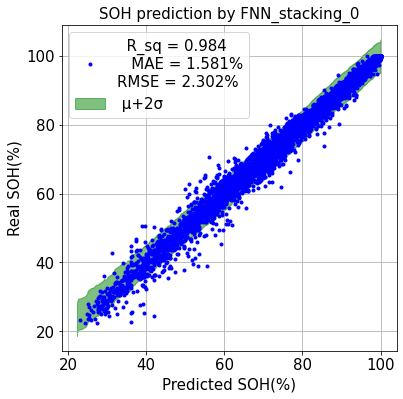

In [8]:
'''加信賴區間後的圖'''
import seaborn as sns
import matplotlib
import scipy.stats as st
matplotlib.rcParams.update({'font.size': 20})

# predicted expect and calculte confidence interval
low_ci_bound, high_ci_bound = st.t.interval(0.95, len(predictions),
                                           loc=predictions,scale=Residuals.std())   #st.sem(y_test_pred_array)
print("low_ci_bound\n", low_ci_bound)
print("high_ci_bound\n", high_ci_bound)
print("std of the SOH\n  = ", np.round(st.sem(predictions),3))

# plot confidence interval
plt.figure(figsize=(6,6))   #, color='green', linestyle='dashed', linewidth = 3, marker='o',
plt.plot(predictions, soh_test2, color='blue', linestyle='None' , marker='.', label=f'  R_sq = {R_sq}\n   MAE = {MAE}%\nRMSE = {RMSE}%')   #, 'b.'
plt.fill_between(sorted(soh_test2), sorted(low_ci_bound), sorted(high_ci_bound), color='green', alpha=0.5,
                label=' μ+2σ')
plt.xlabel("Predicted SOH(%)", fontsize=15) 
plt.ylabel("Real SOH(%)", fontsize=15)
plt.tick_params(labelsize=15)
plt.legend(fontsize=15)
plt.title("SOH prediction by FNN_stacking_0", fontsize=15)
plt.grid()
plt.show()

# RF+RF

In [4]:
'''First RF'''
import time
t1 = time.monotonic()

rmseoos = []
ntreelist = range(200, 250, 50)
for itrees in ntreelist:
    depth = None
    maxft = 3
    model = ensemble.RandomForestRegressor(n_estimators=itrees, max_depth=depth, max_features=maxft, oob_score=False, random_state=100)
    model.fit(features_train2, soh_train2)
    predictions = model.predict(features_test2)
    rmseoos.append(math.sqrt(mean_squared_error(soh_test2, predictions)))
R_sq = np.round(model.fit(features_train2, soh_train2).score(features_test2, soh_test2),3)
MAE = np.round(mean_absolute_error(predictions,soh_test2),3)
RMSE = np.round(np.sqrt(mean_squared_error(predictions,soh_test2)),3)
Residuals = predictions-soh_test2
print("Residuals = ", Residuals)    #print("Best RMSE(%) = ", min(rmseoos))

t2 = time.monotonic()
print("time elapsed: " + str(np.round(t2-t1,3)) + " seconds")

Residuals =  [ 0.4345  3.79    2.6395 ... -1.122  -0.384   2.888 ]
time elapsed: 20.75 seconds


In [ ]:
data_RF2 = np.hstack((data_SOH, data_var))     # 製作normalized features+未調整SOH數據1,
print("data_all\n", data_all[0])